# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

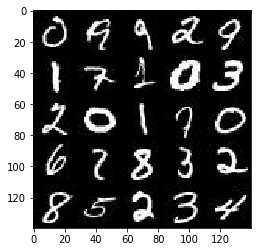

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

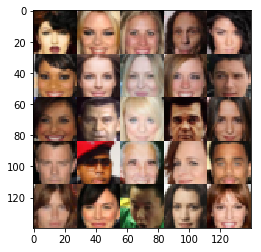

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # DONE: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [8]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # DONE: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer 1
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="SAME",
                              kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        lrelu1 = tf.maximum(alpha * h1, h1)
        #print ('Layer 1:', lrelu1.shape)
        # 14x14x64 now
        
        # Hidden Layer 2
        h2 = tf.layers.conv2d(lrelu1, 128, 5, strides=2, padding="SAME",
                              kernel_initializer =tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(h2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        #print ('Layer 2:', lrelu2.shape)
        # 7x7x128 now
        
        # Hidden Layer 3
        h3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding="SAME", 
                             kernel_initializer =tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(h3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        #print ('Layer 3:', lrelu3.shape)
        #4x4x256 now
        
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2,):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # DONE: Implement Function 
        
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        h1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        bn1 = tf.layers.batch_normalization(h1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        #print ('Layer 1:', lrelu1.shape)
        # 2x2x512 now
        
        # Hidden Layer 2
        h2 = tf.layers.conv2d_transpose(lrelu1, 256, 3, strides=2, padding="SAME")
        bn2 = tf.layers.batch_normalization(h2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        #print ('Layer 2:', lrelu2.shape)
        # 4x4x256 now
        
        # Hidden Layer 3
        h3 = tf.layers.conv2d_transpose(lrelu2, 128, 4, strides=1, padding='VALID')
        bn3 = tf.layers.batch_normalization(h3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        #print ('Layer 3:', h3.shape)
        # 7x7x128
        
        # Hidden Layer 4
        h4 = tf.layers.conv2d_transpose(lrelu3, 64, 3, strides=2, padding='SAME')
        bn4 = tf.layers.batch_normalization(h4, training=is_train)
        lrelu4 = tf.maximum(alpha * bn4, bn4)
        #print ('Layer 3:', h4.shape)
        # 14x14x64
        
        # Output layer, 28x28x5
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 5, strides=2, padding="SAME")
        
        out = tf.tanh(logits)
        #print ('Output:',logits.shape)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # DONE: Implement Function
    smooth = 0.1
    
    # Generator network 
    g_model = generator(input_z, out_channel_dim, is_train=True)

    # Disriminator network
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # Calculate losses
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
     labels=tf.ones_like(d_logits_real) * (1 - smooth)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
     labels=tf.zeros_like(d_logits_real)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # DONE: Implement Function
    
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    
    # https://blog.metaflow.fr/tensorflow-mutating-variables-and-control-flow-2181dd238e62
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # DONE: Build Model   
    
    # Set the image width, height, and image channels
    _, image_width, image_height, image_channels = data_shape
    
    # Impliment model_inputs and set the input_real, input_z, and learning rate
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Impliment model_loss and set the d_loss and g_loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Impliment model_opt and set d_train_opt and g_train_opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Set batch counter
    batch_count = 0
    
    # Set number of images to print
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Multiply batch_images by 2.0 since the dataset ranges from -0.5 to 0.5
                batch_images = batch_images*2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                # Increment the batch_count
                batch_count += 1

                # Print the d_train_loss and g_train_loss every 10 batches
                if (batch_count % 10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                    
                # Print the generator output every 100 batches
                if (batch_count % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5242... Generator Loss: 1.9795
Epoch 1/2... Discriminator Loss: 0.4706... Generator Loss: 3.1612
Epoch 1/2... Discriminator Loss: 0.5122... Generator Loss: 4.9870
Epoch 1/2... Discriminator Loss: 2.9716... Generator Loss: 0.0867
Epoch 1/2... Discriminator Loss: 0.7734... Generator Loss: 2.3643
Epoch 1/2... Discriminator Loss: 0.8414... Generator Loss: 5.3515
Epoch 1/2... Discriminator Loss: 0.5595... Generator Loss: 2.5900
Epoch 1/2... Discriminator Loss: 0.7250... Generator Loss: 1.5981
Epoch 1/2... Discriminator Loss: 0.6925... Generator Loss: 1.6325
Epoch 1/2... Discriminator Loss: 0.4421... Generator Loss: 2.8706


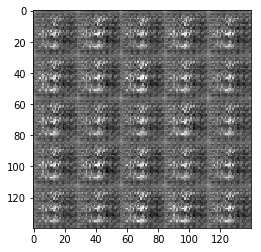

Epoch 1/2... Discriminator Loss: 0.4975... Generator Loss: 2.5066
Epoch 1/2... Discriminator Loss: 0.5369... Generator Loss: 2.3445
Epoch 1/2... Discriminator Loss: 0.4154... Generator Loss: 3.4418
Epoch 1/2... Discriminator Loss: 0.4143... Generator Loss: 3.0205
Epoch 1/2... Discriminator Loss: 0.4351... Generator Loss: 2.9477
Epoch 1/2... Discriminator Loss: 0.4156... Generator Loss: 3.2705
Epoch 1/2... Discriminator Loss: 0.4230... Generator Loss: 3.5503
Epoch 1/2... Discriminator Loss: 0.4426... Generator Loss: 2.9199
Epoch 1/2... Discriminator Loss: 0.4688... Generator Loss: 2.9082
Epoch 1/2... Discriminator Loss: 0.4828... Generator Loss: 2.3157


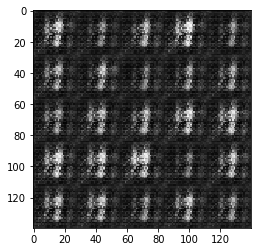

Epoch 1/2... Discriminator Loss: 0.4227... Generator Loss: 3.1667
Epoch 1/2... Discriminator Loss: 0.4428... Generator Loss: 2.9177
Epoch 1/2... Discriminator Loss: 0.4119... Generator Loss: 5.3920
Epoch 1/2... Discriminator Loss: 0.4596... Generator Loss: 4.2058
Epoch 1/2... Discriminator Loss: 0.4612... Generator Loss: 2.6728
Epoch 1/2... Discriminator Loss: 0.4953... Generator Loss: 2.3048
Epoch 1/2... Discriminator Loss: 0.4326... Generator Loss: 3.5862
Epoch 1/2... Discriminator Loss: 0.4075... Generator Loss: 3.5028
Epoch 1/2... Discriminator Loss: 0.3905... Generator Loss: 4.1918
Epoch 1/2... Discriminator Loss: 0.4300... Generator Loss: 3.0838


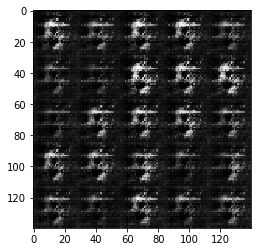

Epoch 1/2... Discriminator Loss: 0.4432... Generator Loss: 2.7828
Epoch 1/2... Discriminator Loss: 0.5251... Generator Loss: 6.5026
Epoch 1/2... Discriminator Loss: 0.4022... Generator Loss: 4.0794
Epoch 1/2... Discriminator Loss: 0.4405... Generator Loss: 3.9578
Epoch 1/2... Discriminator Loss: 0.3674... Generator Loss: 4.7288
Epoch 1/2... Discriminator Loss: 0.4028... Generator Loss: 3.4945
Epoch 1/2... Discriminator Loss: 0.3865... Generator Loss: 4.3028
Epoch 1/2... Discriminator Loss: 0.4378... Generator Loss: 4.3208
Epoch 1/2... Discriminator Loss: 0.4954... Generator Loss: 3.2346
Epoch 1/2... Discriminator Loss: 0.4773... Generator Loss: 2.4391


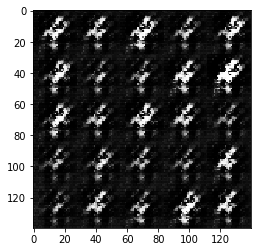

Epoch 1/2... Discriminator Loss: 0.4993... Generator Loss: 4.4547
Epoch 1/2... Discriminator Loss: 0.4872... Generator Loss: 2.3488
Epoch 1/2... Discriminator Loss: 0.6647... Generator Loss: 1.6546
Epoch 1/2... Discriminator Loss: 0.6557... Generator Loss: 1.8917
Epoch 1/2... Discriminator Loss: 0.4877... Generator Loss: 3.9211
Epoch 1/2... Discriminator Loss: 0.4678... Generator Loss: 2.8162
Epoch 1/2... Discriminator Loss: 0.4340... Generator Loss: 3.0932
Epoch 1/2... Discriminator Loss: 0.5032... Generator Loss: 3.0394
Epoch 1/2... Discriminator Loss: 0.4341... Generator Loss: 3.4117
Epoch 1/2... Discriminator Loss: 0.5066... Generator Loss: 3.4409


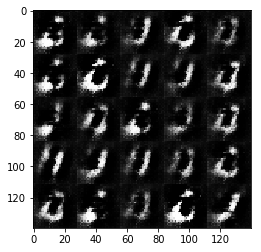

Epoch 1/2... Discriminator Loss: 1.5605... Generator Loss: 6.7014
Epoch 1/2... Discriminator Loss: 0.4637... Generator Loss: 3.4067
Epoch 1/2... Discriminator Loss: 0.4640... Generator Loss: 2.7782
Epoch 1/2... Discriminator Loss: 0.4215... Generator Loss: 3.6753
Epoch 1/2... Discriminator Loss: 0.4549... Generator Loss: 2.8816
Epoch 1/2... Discriminator Loss: 0.7970... Generator Loss: 6.3063
Epoch 1/2... Discriminator Loss: 0.4736... Generator Loss: 3.2381
Epoch 1/2... Discriminator Loss: 0.4381... Generator Loss: 3.1980
Epoch 1/2... Discriminator Loss: 0.5666... Generator Loss: 1.9951
Epoch 1/2... Discriminator Loss: 0.6091... Generator Loss: 2.2284


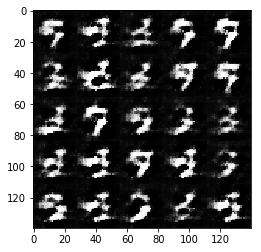

Epoch 1/2... Discriminator Loss: 0.4971... Generator Loss: 3.4734
Epoch 1/2... Discriminator Loss: 0.4553... Generator Loss: 3.7256
Epoch 1/2... Discriminator Loss: 0.4771... Generator Loss: 2.8798
Epoch 1/2... Discriminator Loss: 0.5099... Generator Loss: 3.9141
Epoch 1/2... Discriminator Loss: 0.6120... Generator Loss: 1.7415
Epoch 1/2... Discriminator Loss: 0.5328... Generator Loss: 2.9685
Epoch 1/2... Discriminator Loss: 0.5336... Generator Loss: 3.2885
Epoch 1/2... Discriminator Loss: 0.4966... Generator Loss: 2.3709
Epoch 1/2... Discriminator Loss: 0.7062... Generator Loss: 1.6604
Epoch 1/2... Discriminator Loss: 0.5162... Generator Loss: 2.6781


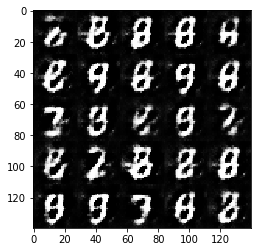

Epoch 1/2... Discriminator Loss: 0.5060... Generator Loss: 3.0457
Epoch 1/2... Discriminator Loss: 0.5788... Generator Loss: 2.3239
Epoch 1/2... Discriminator Loss: 0.5112... Generator Loss: 4.2165
Epoch 1/2... Discriminator Loss: 0.8128... Generator Loss: 4.2105
Epoch 1/2... Discriminator Loss: 0.4931... Generator Loss: 2.5952
Epoch 1/2... Discriminator Loss: 0.4334... Generator Loss: 3.1611
Epoch 1/2... Discriminator Loss: 0.9985... Generator Loss: 5.5657
Epoch 1/2... Discriminator Loss: 0.5783... Generator Loss: 2.2963
Epoch 1/2... Discriminator Loss: 0.6997... Generator Loss: 3.9097
Epoch 1/2... Discriminator Loss: 0.5326... Generator Loss: 2.2427


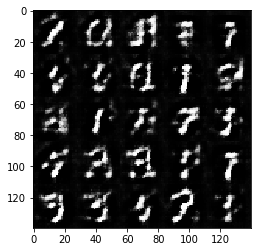

Epoch 1/2... Discriminator Loss: 0.5677... Generator Loss: 3.9111
Epoch 1/2... Discriminator Loss: 0.6058... Generator Loss: 2.4431
Epoch 1/2... Discriminator Loss: 0.6193... Generator Loss: 1.9292
Epoch 1/2... Discriminator Loss: 1.2146... Generator Loss: 1.0374
Epoch 1/2... Discriminator Loss: 0.5846... Generator Loss: 2.7881
Epoch 1/2... Discriminator Loss: 0.7641... Generator Loss: 4.2641
Epoch 1/2... Discriminator Loss: 0.7966... Generator Loss: 1.3389
Epoch 1/2... Discriminator Loss: 0.6965... Generator Loss: 3.0154
Epoch 1/2... Discriminator Loss: 0.6888... Generator Loss: 2.3081
Epoch 1/2... Discriminator Loss: 0.6958... Generator Loss: 2.1769


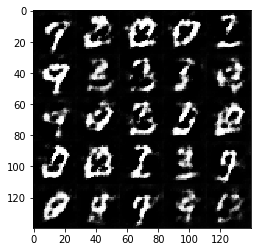

Epoch 1/2... Discriminator Loss: 0.6572... Generator Loss: 2.1191
Epoch 1/2... Discriminator Loss: 0.6448... Generator Loss: 2.8402
Epoch 1/2... Discriminator Loss: 0.7683... Generator Loss: 1.4344
Epoch 2/2... Discriminator Loss: 0.7127... Generator Loss: 1.9204
Epoch 2/2... Discriminator Loss: 0.5689... Generator Loss: 3.3369
Epoch 2/2... Discriminator Loss: 0.8913... Generator Loss: 1.1874
Epoch 2/2... Discriminator Loss: 1.1964... Generator Loss: 0.7457
Epoch 2/2... Discriminator Loss: 0.5600... Generator Loss: 2.7889
Epoch 2/2... Discriminator Loss: 0.6822... Generator Loss: 1.7166
Epoch 2/2... Discriminator Loss: 0.5918... Generator Loss: 2.7025


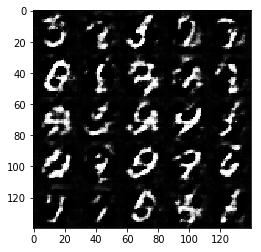

Epoch 2/2... Discriminator Loss: 0.5217... Generator Loss: 2.7225
Epoch 2/2... Discriminator Loss: 0.7016... Generator Loss: 1.9731
Epoch 2/2... Discriminator Loss: 0.9163... Generator Loss: 1.0823
Epoch 2/2... Discriminator Loss: 0.6720... Generator Loss: 1.7783
Epoch 2/2... Discriminator Loss: 0.6992... Generator Loss: 1.8104
Epoch 2/2... Discriminator Loss: 0.7461... Generator Loss: 2.6862
Epoch 2/2... Discriminator Loss: 0.7754... Generator Loss: 1.6311
Epoch 2/2... Discriminator Loss: 0.6890... Generator Loss: 1.8261
Epoch 2/2... Discriminator Loss: 0.6547... Generator Loss: 2.4347
Epoch 2/2... Discriminator Loss: 0.7913... Generator Loss: 2.3434


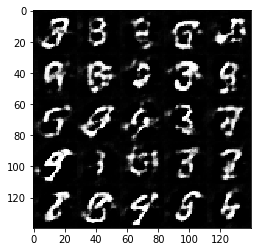

Epoch 2/2... Discriminator Loss: 0.6041... Generator Loss: 2.1606
Epoch 2/2... Discriminator Loss: 0.7389... Generator Loss: 1.4917
Epoch 2/2... Discriminator Loss: 1.0358... Generator Loss: 3.6556
Epoch 2/2... Discriminator Loss: 0.7389... Generator Loss: 1.6134
Epoch 2/2... Discriminator Loss: 0.7185... Generator Loss: 3.2942
Epoch 2/2... Discriminator Loss: 0.7686... Generator Loss: 1.6551
Epoch 2/2... Discriminator Loss: 0.6935... Generator Loss: 1.7655
Epoch 2/2... Discriminator Loss: 0.8594... Generator Loss: 1.6863
Epoch 2/2... Discriminator Loss: 0.8686... Generator Loss: 1.0836
Epoch 2/2... Discriminator Loss: 0.7598... Generator Loss: 1.3691


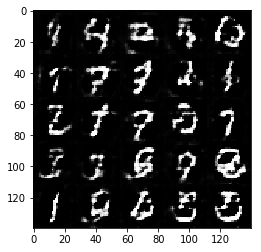

Epoch 2/2... Discriminator Loss: 0.8249... Generator Loss: 1.1917
Epoch 2/2... Discriminator Loss: 0.7935... Generator Loss: 1.4287
Epoch 2/2... Discriminator Loss: 0.7144... Generator Loss: 1.8052
Epoch 2/2... Discriminator Loss: 0.7162... Generator Loss: 1.4982
Epoch 2/2... Discriminator Loss: 0.6974... Generator Loss: 1.9585
Epoch 2/2... Discriminator Loss: 1.0313... Generator Loss: 2.4240
Epoch 2/2... Discriminator Loss: 0.9636... Generator Loss: 3.0136
Epoch 2/2... Discriminator Loss: 0.7201... Generator Loss: 1.5575
Epoch 2/2... Discriminator Loss: 0.6529... Generator Loss: 2.0459
Epoch 2/2... Discriminator Loss: 0.7760... Generator Loss: 1.8948


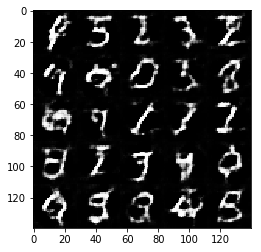

Epoch 2/2... Discriminator Loss: 0.7453... Generator Loss: 1.9215
Epoch 2/2... Discriminator Loss: 0.7873... Generator Loss: 1.4277
Epoch 2/2... Discriminator Loss: 1.3499... Generator Loss: 0.5544
Epoch 2/2... Discriminator Loss: 0.8440... Generator Loss: 1.2979
Epoch 2/2... Discriminator Loss: 0.8844... Generator Loss: 1.1266
Epoch 2/2... Discriminator Loss: 0.7588... Generator Loss: 1.3352
Epoch 2/2... Discriminator Loss: 0.9309... Generator Loss: 2.4858
Epoch 2/2... Discriminator Loss: 0.9710... Generator Loss: 2.1250
Epoch 2/2... Discriminator Loss: 0.8525... Generator Loss: 1.1733
Epoch 2/2... Discriminator Loss: 1.0951... Generator Loss: 2.9573


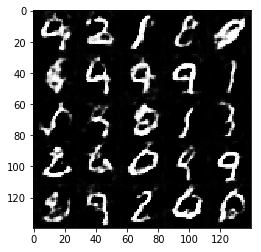

Epoch 2/2... Discriminator Loss: 0.9098... Generator Loss: 2.6707
Epoch 2/2... Discriminator Loss: 0.7115... Generator Loss: 1.7260
Epoch 2/2... Discriminator Loss: 0.7099... Generator Loss: 1.6881
Epoch 2/2... Discriminator Loss: 0.8878... Generator Loss: 1.0331
Epoch 2/2... Discriminator Loss: 0.9433... Generator Loss: 0.9777
Epoch 2/2... Discriminator Loss: 0.7358... Generator Loss: 2.3763
Epoch 2/2... Discriminator Loss: 0.9435... Generator Loss: 2.4959
Epoch 2/2... Discriminator Loss: 1.2049... Generator Loss: 0.6464
Epoch 2/2... Discriminator Loss: 0.8439... Generator Loss: 2.1457
Epoch 2/2... Discriminator Loss: 1.2848... Generator Loss: 0.6037


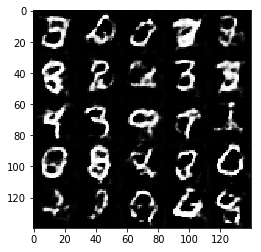

Epoch 2/2... Discriminator Loss: 0.9628... Generator Loss: 0.9934
Epoch 2/2... Discriminator Loss: 0.8982... Generator Loss: 1.0399
Epoch 2/2... Discriminator Loss: 1.0527... Generator Loss: 0.8178
Epoch 2/2... Discriminator Loss: 0.8077... Generator Loss: 1.7554
Epoch 2/2... Discriminator Loss: 0.7147... Generator Loss: 1.4505
Epoch 2/2... Discriminator Loss: 0.9276... Generator Loss: 1.0154
Epoch 2/2... Discriminator Loss: 0.7907... Generator Loss: 2.0734
Epoch 2/2... Discriminator Loss: 0.8421... Generator Loss: 1.1404
Epoch 2/2... Discriminator Loss: 0.7375... Generator Loss: 1.5179
Epoch 2/2... Discriminator Loss: 0.7619... Generator Loss: 1.3120


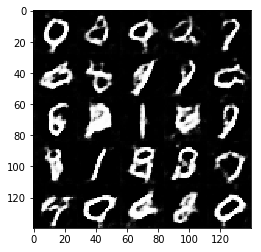

Epoch 2/2... Discriminator Loss: 0.7808... Generator Loss: 1.2307
Epoch 2/2... Discriminator Loss: 0.8007... Generator Loss: 2.0920
Epoch 2/2... Discriminator Loss: 0.7581... Generator Loss: 1.3856
Epoch 2/2... Discriminator Loss: 1.2365... Generator Loss: 0.6516
Epoch 2/2... Discriminator Loss: 0.8439... Generator Loss: 1.0786
Epoch 2/2... Discriminator Loss: 0.6964... Generator Loss: 1.6058
Epoch 2/2... Discriminator Loss: 0.7794... Generator Loss: 2.1635
Epoch 2/2... Discriminator Loss: 1.1448... Generator Loss: 3.0559
Epoch 2/2... Discriminator Loss: 0.8587... Generator Loss: 1.1947
Epoch 2/2... Discriminator Loss: 0.7203... Generator Loss: 1.4005


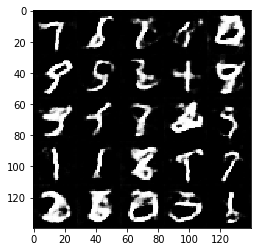

Epoch 2/2... Discriminator Loss: 0.7354... Generator Loss: 1.5027
Epoch 2/2... Discriminator Loss: 0.7441... Generator Loss: 1.4858
Epoch 2/2... Discriminator Loss: 0.8100... Generator Loss: 1.2206
Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 2.4722
Epoch 2/2... Discriminator Loss: 1.1766... Generator Loss: 0.6705
Epoch 2/2... Discriminator Loss: 0.7424... Generator Loss: 1.5100
Epoch 2/2... Discriminator Loss: 0.7512... Generator Loss: 1.4610
Epoch 2/2... Discriminator Loss: 0.8608... Generator Loss: 1.1322
Epoch 2/2... Discriminator Loss: 1.3013... Generator Loss: 3.0443
Epoch 2/2... Discriminator Loss: 0.8258... Generator Loss: 1.1876


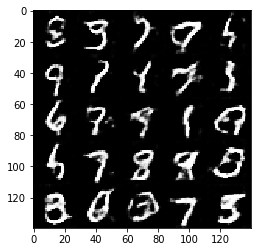

Epoch 2/2... Discriminator Loss: 0.8003... Generator Loss: 1.4061
Epoch 2/2... Discriminator Loss: 0.7359... Generator Loss: 1.3786
Epoch 2/2... Discriminator Loss: 0.8541... Generator Loss: 1.0375
Epoch 2/2... Discriminator Loss: 0.6817... Generator Loss: 1.7623
Epoch 2/2... Discriminator Loss: 0.9633... Generator Loss: 2.8465
Epoch 2/2... Discriminator Loss: 0.8295... Generator Loss: 1.1709
Epoch 2/2... Discriminator Loss: 0.8873... Generator Loss: 1.1535


In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6390... Generator Loss: 1.9816
Epoch 1/1... Discriminator Loss: 0.5290... Generator Loss: 2.2176
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 10.8456
Epoch 1/1... Discriminator Loss: 0.4629... Generator Loss: 8.0822
Epoch 1/1... Discriminator Loss: 0.4088... Generator Loss: 4.1266
Epoch 1/1... Discriminator Loss: 0.4879... Generator Loss: 2.8752
Epoch 1/1... Discriminator Loss: 0.4638... Generator Loss: 8.0487
Epoch 1/1... Discriminator Loss: 0.5193... Generator Loss: 2.5592
Epoch 1/1... Discriminator Loss: 0.4325... Generator Loss: 4.2867
Epoch 1/1... Discriminator Loss: 0.5560... Generator Loss: 2.0126


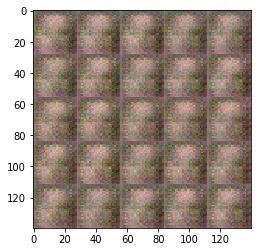

Epoch 1/1... Discriminator Loss: 0.6102... Generator Loss: 1.9202
Epoch 1/1... Discriminator Loss: 0.4843... Generator Loss: 2.3316
Epoch 1/1... Discriminator Loss: 0.4116... Generator Loss: 4.0017
Epoch 1/1... Discriminator Loss: 0.5020... Generator Loss: 2.8493
Epoch 1/1... Discriminator Loss: 0.4426... Generator Loss: 3.5306
Epoch 1/1... Discriminator Loss: 0.4228... Generator Loss: 3.3255
Epoch 1/1... Discriminator Loss: 0.4140... Generator Loss: 4.7234
Epoch 1/1... Discriminator Loss: 0.4150... Generator Loss: 3.2404
Epoch 1/1... Discriminator Loss: 0.4001... Generator Loss: 3.3842
Epoch 1/1... Discriminator Loss: 0.3797... Generator Loss: 3.7649


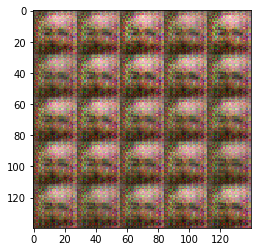

Epoch 1/1... Discriminator Loss: 0.5084... Generator Loss: 2.3955
Epoch 1/1... Discriminator Loss: 0.3969... Generator Loss: 3.6268
Epoch 1/1... Discriminator Loss: 0.7789... Generator Loss: 1.1986
Epoch 1/1... Discriminator Loss: 0.6189... Generator Loss: 2.7408
Epoch 1/1... Discriminator Loss: 0.6826... Generator Loss: 1.6857
Epoch 1/1... Discriminator Loss: 0.6764... Generator Loss: 3.1658
Epoch 1/1... Discriminator Loss: 0.5882... Generator Loss: 1.7959
Epoch 1/1... Discriminator Loss: 0.4571... Generator Loss: 3.9123
Epoch 1/1... Discriminator Loss: 0.5798... Generator Loss: 1.7368
Epoch 1/1... Discriminator Loss: 0.5126... Generator Loss: 3.8230


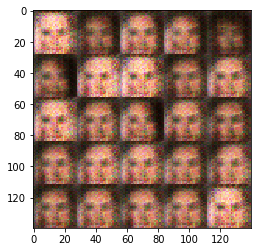

Epoch 1/1... Discriminator Loss: 0.5211... Generator Loss: 2.8016
Epoch 1/1... Discriminator Loss: 0.5049... Generator Loss: 2.3734
Epoch 1/1... Discriminator Loss: 0.5842... Generator Loss: 3.9029
Epoch 1/1... Discriminator Loss: 0.4978... Generator Loss: 2.8684
Epoch 1/1... Discriminator Loss: 0.6340... Generator Loss: 2.2557
Epoch 1/1... Discriminator Loss: 0.5473... Generator Loss: 3.3324
Epoch 1/1... Discriminator Loss: 0.5166... Generator Loss: 2.4083
Epoch 1/1... Discriminator Loss: 0.6252... Generator Loss: 2.2475
Epoch 1/1... Discriminator Loss: 0.5753... Generator Loss: 2.4265
Epoch 1/1... Discriminator Loss: 0.7100... Generator Loss: 1.4961


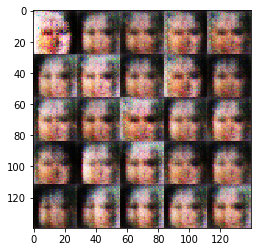

Epoch 1/1... Discriminator Loss: 0.6502... Generator Loss: 1.6090
Epoch 1/1... Discriminator Loss: 0.5634... Generator Loss: 2.4900
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 5.4734
Epoch 1/1... Discriminator Loss: 0.5279... Generator Loss: 2.5850
Epoch 1/1... Discriminator Loss: 0.5512... Generator Loss: 3.6780
Epoch 1/1... Discriminator Loss: 0.5100... Generator Loss: 2.4679
Epoch 1/1... Discriminator Loss: 0.4308... Generator Loss: 4.9033
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 0.6406... Generator Loss: 4.0783
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.0446


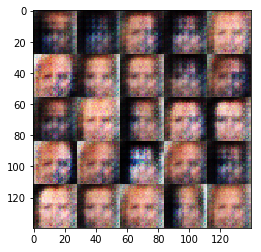

Epoch 1/1... Discriminator Loss: 0.7372... Generator Loss: 2.9644
Epoch 1/1... Discriminator Loss: 0.7572... Generator Loss: 2.0061
Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 4.5507
Epoch 1/1... Discriminator Loss: 0.6184... Generator Loss: 1.7144
Epoch 1/1... Discriminator Loss: 0.6689... Generator Loss: 1.8799
Epoch 1/1... Discriminator Loss: 0.6199... Generator Loss: 2.2904
Epoch 1/1... Discriminator Loss: 0.7576... Generator Loss: 2.7054
Epoch 1/1... Discriminator Loss: 0.5667... Generator Loss: 2.2511
Epoch 1/1... Discriminator Loss: 0.6113... Generator Loss: 2.0242
Epoch 1/1... Discriminator Loss: 0.7178... Generator Loss: 1.4360


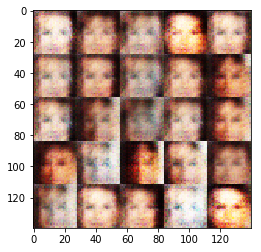

Epoch 1/1... Discriminator Loss: 0.5378... Generator Loss: 3.5366
Epoch 1/1... Discriminator Loss: 0.6498... Generator Loss: 3.0752
Epoch 1/1... Discriminator Loss: 1.7130... Generator Loss: 6.1986
Epoch 1/1... Discriminator Loss: 0.6866... Generator Loss: 3.3467
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 2.3199
Epoch 1/1... Discriminator Loss: 0.5497... Generator Loss: 2.7828
Epoch 1/1... Discriminator Loss: 0.5918... Generator Loss: 2.5631
Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 1.4027
Epoch 1/1... Discriminator Loss: 0.6467... Generator Loss: 3.2398


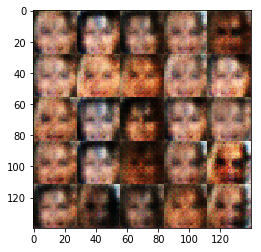

Epoch 1/1... Discriminator Loss: 0.7287... Generator Loss: 1.6825
Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 1.3105
Epoch 1/1... Discriminator Loss: 0.7857... Generator Loss: 1.4156
Epoch 1/1... Discriminator Loss: 0.5865... Generator Loss: 2.5424
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 3.3929
Epoch 1/1... Discriminator Loss: 0.7449... Generator Loss: 2.0391
Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 3.2262
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 1.5836
Epoch 1/1... Discriminator Loss: 0.6947... Generator Loss: 1.6822


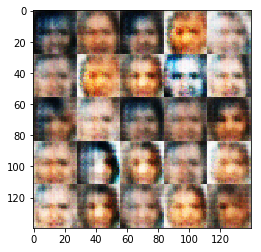

Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 1.2327
Epoch 1/1... Discriminator Loss: 0.7057... Generator Loss: 1.7441
Epoch 1/1... Discriminator Loss: 0.6639... Generator Loss: 2.5294
Epoch 1/1... Discriminator Loss: 0.7293... Generator Loss: 1.4177
Epoch 1/1... Discriminator Loss: 0.6566... Generator Loss: 2.4533
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 4.6536
Epoch 1/1... Discriminator Loss: 0.7781... Generator Loss: 1.4783
Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 1.6642
Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 1.8787
Epoch 1/1... Discriminator Loss: 0.5754... Generator Loss: 2.1963


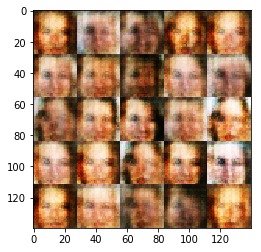

Epoch 1/1... Discriminator Loss: 0.7033... Generator Loss: 2.1533
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 4.0338
Epoch 1/1... Discriminator Loss: 0.6118... Generator Loss: 2.3013
Epoch 1/1... Discriminator Loss: 0.6986... Generator Loss: 2.2899
Epoch 1/1... Discriminator Loss: 0.6299... Generator Loss: 1.8778
Epoch 1/1... Discriminator Loss: 1.5259... Generator Loss: 0.5247
Epoch 1/1... Discriminator Loss: 0.7572... Generator Loss: 1.7018
Epoch 1/1... Discriminator Loss: 0.8245... Generator Loss: 1.8179
Epoch 1/1... Discriminator Loss: 0.6573... Generator Loss: 2.2202
Epoch 1/1... Discriminator Loss: 0.6094... Generator Loss: 2.1181


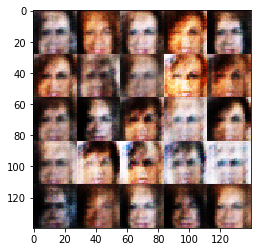

Epoch 1/1... Discriminator Loss: 0.7294... Generator Loss: 2.3506
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 2.5840
Epoch 1/1... Discriminator Loss: 0.6539... Generator Loss: 2.7727
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.8940
Epoch 1/1... Discriminator Loss: 0.7696... Generator Loss: 1.6158
Epoch 1/1... Discriminator Loss: 0.6617... Generator Loss: 2.5723
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 4.4716
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 1.1925
Epoch 1/1... Discriminator Loss: 0.6576... Generator Loss: 2.0111


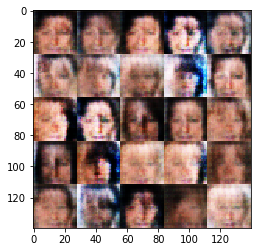

Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 0.8190... Generator Loss: 1.2531
Epoch 1/1... Discriminator Loss: 0.7887... Generator Loss: 1.2307
Epoch 1/1... Discriminator Loss: 0.8133... Generator Loss: 2.3616
Epoch 1/1... Discriminator Loss: 0.7829... Generator Loss: 1.5162
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.2852
Epoch 1/1... Discriminator Loss: 0.6204... Generator Loss: 2.0619
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 1.1173
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 0.6589... Generator Loss: 1.8733


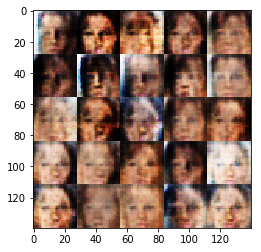

Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 0.6967... Generator Loss: 1.9279
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 1.0307
Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.2511
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 2.4835
Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 2.0943
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 1.9641
Epoch 1/1... Discriminator Loss: 0.7986... Generator Loss: 2.0883


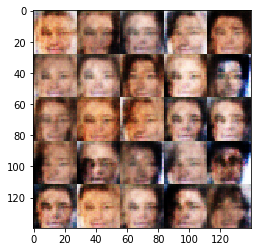

Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 2.1038
Epoch 1/1... Discriminator Loss: 0.6013... Generator Loss: 2.6989
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 1.2429
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 1.2886
Epoch 1/1... Discriminator Loss: 0.8091... Generator Loss: 1.8774
Epoch 1/1... Discriminator Loss: 0.7581... Generator Loss: 2.8241
Epoch 1/1... Discriminator Loss: 0.6979... Generator Loss: 1.7134
Epoch 1/1... Discriminator Loss: 0.6930... Generator Loss: 1.6816
Epoch 1/1... Discriminator Loss: 0.8178... Generator Loss: 1.2816
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 2.9413


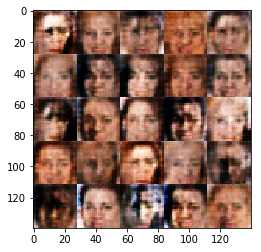

Epoch 1/1... Discriminator Loss: 0.7851... Generator Loss: 1.3387
Epoch 1/1... Discriminator Loss: 0.7069... Generator Loss: 1.9458
Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 1.4599
Epoch 1/1... Discriminator Loss: 0.8457... Generator Loss: 1.9311
Epoch 1/1... Discriminator Loss: 0.9807... Generator Loss: 1.0828
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.5777
Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 1.3060
Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 1.5786
Epoch 1/1... Discriminator Loss: 0.8287... Generator Loss: 2.2625
Epoch 1/1... Discriminator Loss: 0.6969... Generator Loss: 1.5832


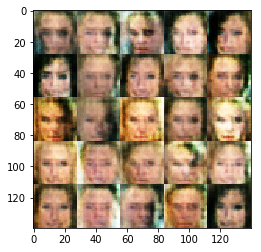

Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 2.6810
Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 1.3216
Epoch 1/1... Discriminator Loss: 0.8648... Generator Loss: 1.8456
Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 1.2539
Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 1.2522
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 0.9875
Epoch 1/1... Discriminator Loss: 0.7595... Generator Loss: 1.4660
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 1.6034
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 0.7717... Generator Loss: 1.7806


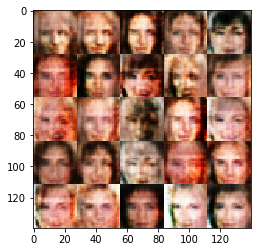

Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 2.6915
Epoch 1/1... Discriminator Loss: 0.7908... Generator Loss: 1.6095
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 3.9255
Epoch 1/1... Discriminator Loss: 0.7536... Generator Loss: 2.3488
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 0.7556... Generator Loss: 2.1189
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 1.2031
Epoch 1/1... Discriminator Loss: 0.8952... Generator Loss: 1.4335
Epoch 1/1... Discriminator Loss: 0.6998... Generator Loss: 1.8575
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 1.3898


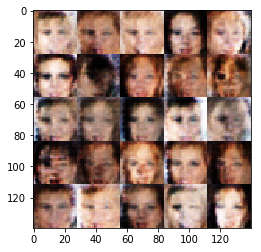

Epoch 1/1... Discriminator Loss: 1.7521... Generator Loss: 0.3663
Epoch 1/1... Discriminator Loss: 0.8753... Generator Loss: 1.9730
Epoch 1/1... Discriminator Loss: 0.7985... Generator Loss: 1.4266
Epoch 1/1... Discriminator Loss: 0.7432... Generator Loss: 2.1880
Epoch 1/1... Discriminator Loss: 0.7599... Generator Loss: 1.3497
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 0.7024... Generator Loss: 1.9025
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 1.2117
Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 1.7947


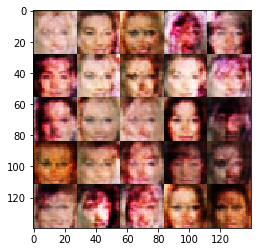

Epoch 1/1... Discriminator Loss: 0.7760... Generator Loss: 2.1126
Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 2.3863
Epoch 1/1... Discriminator Loss: 0.7443... Generator Loss: 1.8653
Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 1.8489
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 2.7299
Epoch 1/1... Discriminator Loss: 0.7275... Generator Loss: 1.7533
Epoch 1/1... Discriminator Loss: 0.8464... Generator Loss: 1.5335
Epoch 1/1... Discriminator Loss: 0.6892... Generator Loss: 1.9536
Epoch 1/1... Discriminator Loss: 0.8007... Generator Loss: 1.4011
Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 2.3761


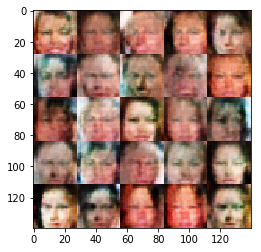

Epoch 1/1... Discriminator Loss: 0.9318... Generator Loss: 1.6552
Epoch 1/1... Discriminator Loss: 0.9045... Generator Loss: 1.8708
Epoch 1/1... Discriminator Loss: 0.8242... Generator Loss: 1.4932
Epoch 1/1... Discriminator Loss: 0.7432... Generator Loss: 2.3196
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 1.2974
Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 1.4204
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 1.9676
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 0.9823
Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 1.4665


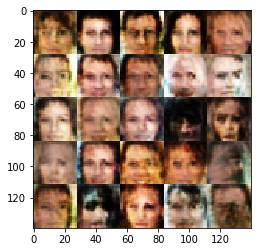

Epoch 1/1... Discriminator Loss: 0.7596... Generator Loss: 1.5588
Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 2.1685
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 0.9078... Generator Loss: 1.3862
Epoch 1/1... Discriminator Loss: 0.6991... Generator Loss: 1.8959
Epoch 1/1... Discriminator Loss: 0.8607... Generator Loss: 2.0968
Epoch 1/1... Discriminator Loss: 0.6988... Generator Loss: 1.6560
Epoch 1/1... Discriminator Loss: 0.7763... Generator Loss: 2.0573
Epoch 1/1... Discriminator Loss: 0.8921... Generator Loss: 1.1367
Epoch 1/1... Discriminator Loss: 0.6989... Generator Loss: 1.8628


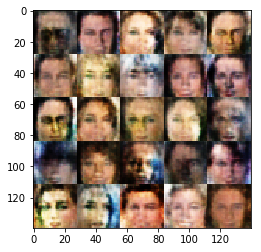

Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 1.1873
Epoch 1/1... Discriminator Loss: 0.9140... Generator Loss: 1.1378
Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 1.5264
Epoch 1/1... Discriminator Loss: 0.7218... Generator Loss: 1.8019
Epoch 1/1... Discriminator Loss: 1.9933... Generator Loss: 0.3183
Epoch 1/1... Discriminator Loss: 0.7339... Generator Loss: 2.1368
Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 2.0872
Epoch 1/1... Discriminator Loss: 0.8350... Generator Loss: 1.6969
Epoch 1/1... Discriminator Loss: 0.7816... Generator Loss: 1.7977
Epoch 1/1... Discriminator Loss: 0.7809... Generator Loss: 2.7833


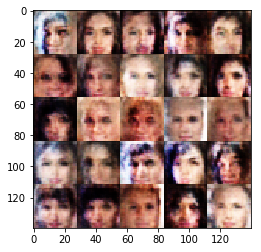

Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 1.2089
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 1.1751
Epoch 1/1... Discriminator Loss: 0.7092... Generator Loss: 1.5600
Epoch 1/1... Discriminator Loss: 0.7589... Generator Loss: 2.4253
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 2.1892
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 0.7970... Generator Loss: 2.4406
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 1.7701
Epoch 1/1... Discriminator Loss: 0.9435... Generator Loss: 1.1300


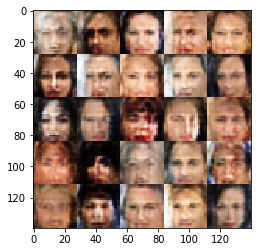

Epoch 1/1... Discriminator Loss: 0.9362... Generator Loss: 1.0360
Epoch 1/1... Discriminator Loss: 0.7979... Generator Loss: 2.0746
Epoch 1/1... Discriminator Loss: 0.7663... Generator Loss: 1.5324
Epoch 1/1... Discriminator Loss: 0.8017... Generator Loss: 2.0768
Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 1.5837
Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 1.5083
Epoch 1/1... Discriminator Loss: 0.7654... Generator Loss: 2.5981
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 2.2769
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 2.3019
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 2.6762


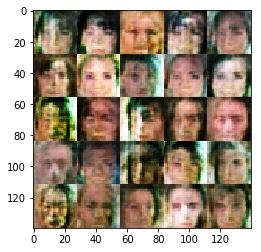

Epoch 1/1... Discriminator Loss: 0.7084... Generator Loss: 1.5091
Epoch 1/1... Discriminator Loss: 0.7190... Generator Loss: 1.8200
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 0.8121... Generator Loss: 1.3962
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.9423
Epoch 1/1... Discriminator Loss: 0.6706... Generator Loss: 2.1156
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 1.3373
Epoch 1/1... Discriminator Loss: 0.8038... Generator Loss: 1.4699


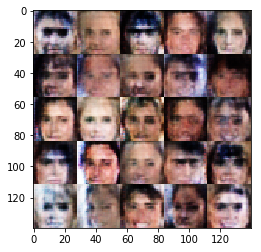

Epoch 1/1... Discriminator Loss: 0.7767... Generator Loss: 2.0169
Epoch 1/1... Discriminator Loss: 0.7082... Generator Loss: 1.8245
Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 1.0719
Epoch 1/1... Discriminator Loss: 0.7382... Generator Loss: 1.7045
Epoch 1/1... Discriminator Loss: 0.8699... Generator Loss: 2.7315
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 2.3075
Epoch 1/1... Discriminator Loss: 0.7350... Generator Loss: 1.5438
Epoch 1/1... Discriminator Loss: 0.7969... Generator Loss: 1.6858


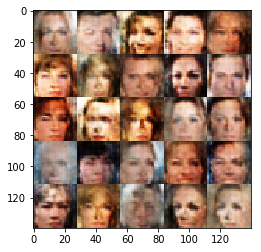

Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.4945
Epoch 1/1... Discriminator Loss: 0.8140... Generator Loss: 1.8530
Epoch 1/1... Discriminator Loss: 0.7577... Generator Loss: 1.6836
Epoch 1/1... Discriminator Loss: 0.7543... Generator Loss: 1.6493
Epoch 1/1... Discriminator Loss: 0.7954... Generator Loss: 1.5534
Epoch 1/1... Discriminator Loss: 0.8157... Generator Loss: 1.3199
Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.0472
Epoch 1/1... Discriminator Loss: 0.8174... Generator Loss: 1.3089
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 1.2481
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 0.7439


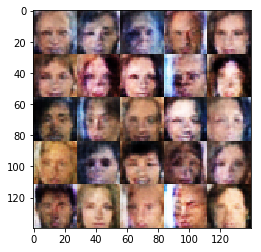

Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.3078
Epoch 1/1... Discriminator Loss: 0.7114... Generator Loss: 2.1512
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 3.2971
Epoch 1/1... Discriminator Loss: 0.7383... Generator Loss: 1.8565
Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 1.4412
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 1.1526
Epoch 1/1... Discriminator Loss: 0.8963... Generator Loss: 2.8200
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 1.4980
Epoch 1/1... Discriminator Loss: 0.8488... Generator Loss: 1.7055
Epoch 1/1... Discriminator Loss: 0.7957... Generator Loss: 1.6963


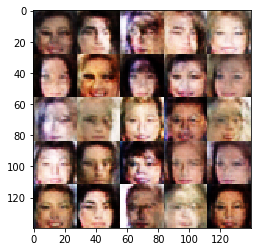

Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 1.8301
Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 1.4929
Epoch 1/1... Discriminator Loss: 0.7535... Generator Loss: 2.2182
Epoch 1/1... Discriminator Loss: 0.7405... Generator Loss: 2.0503
Epoch 1/1... Discriminator Loss: 0.7407... Generator Loss: 1.4830
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.7116
Epoch 1/1... Discriminator Loss: 0.8078... Generator Loss: 2.0756
Epoch 1/1... Discriminator Loss: 0.7688... Generator Loss: 1.3510
Epoch 1/1... Discriminator Loss: 0.7020... Generator Loss: 1.4816
Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 1.2754


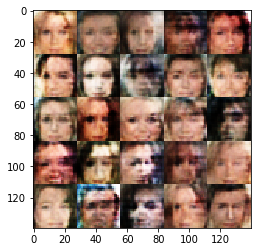

Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 1.5256
Epoch 1/1... Discriminator Loss: 0.8420... Generator Loss: 1.1668
Epoch 1/1... Discriminator Loss: 0.7979... Generator Loss: 1.5794
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 1.4282
Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 2.0100
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 1.3366
Epoch 1/1... Discriminator Loss: 0.7765... Generator Loss: 1.8667
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 1.2917
Epoch 1/1... Discriminator Loss: 0.8486... Generator Loss: 1.3033
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 1.2072


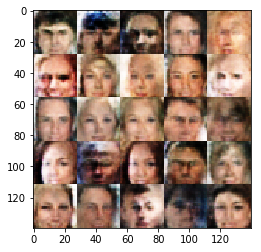

Epoch 1/1... Discriminator Loss: 0.7864... Generator Loss: 1.3182
Epoch 1/1... Discriminator Loss: 0.8746... Generator Loss: 1.3233
Epoch 1/1... Discriminator Loss: 0.8535... Generator Loss: 1.3100
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 1.4763
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 0.7237... Generator Loss: 1.7473
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.4187
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 1.1171
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 2.8167


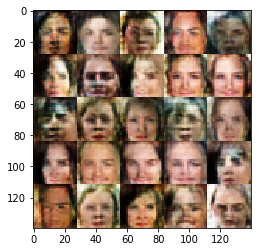

Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 2.5780
Epoch 1/1... Discriminator Loss: 0.6387... Generator Loss: 2.4404
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 2.2498
Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 1.2421
Epoch 1/1... Discriminator Loss: 0.8473... Generator Loss: 1.7564
Epoch 1/1... Discriminator Loss: 0.8039... Generator Loss: 1.3531


In [27]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.